# |In this notebook we attempt to fit a SIR model to data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.sir import SIROneStain

# Load data

In [25]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])

In [27]:
df.date

0     2020-03-12
1     2020-03-13
2     2020-03-14
3     2020-03-15
4     2020-03-16
         ...    
304   2021-01-10
305   2021-01-11
306   2021-01-12
307   2021-01-13
308   2021-01-14
Name: date, Length: 309, dtype: datetime64[ns]

# Set global params

In [28]:
population = 12_000_000
#population = 140_000_000

In [29]:
start_day = df.iloc[0].date
end_day = df.iloc[-1].date
days_in_cycle = 1
dates = pd.date_range(start=start_day,
                      end=end_day,
                      freq=f"{days_in_cycle}D")

t = np.arange(len(dates))
len(t)

309

# SIR first peak

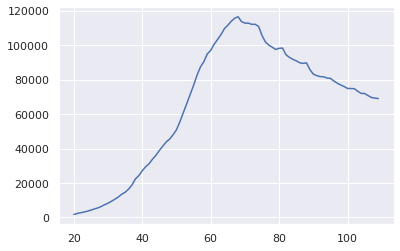

In [30]:
df[20:110]['infected'].plot()

In [31]:
df[20:110]['infected']

20      1749
21      2316
22      2735
23      3136
24      3666
       ...  
105    71928
106    70719
107    69597
108    69238
109    68990
Name: infected, Length: 90, dtype: int64

In [32]:
model = SIROneStain(population)

subset = df[20:110]
model.fit(subset)

result = model.fit_result_
#result.plot_fit(datafmt="-");
result

In [33]:
R0 = result.params['beta']/result.params['gamma']
R0

1.0044197367573897

In [34]:
S, I, R, D = model.predict_train()

In [35]:
R[0], I[0], D[0]

(0.0, 2543.5474613639817, 0.0)

In [36]:
R[20]

3867.0564550352174

In [37]:
I[:20].cumsum()[-1]

51711.63077657474

In [38]:
I[:20].cumsum()[-1]/R[20]

13.372349583684525

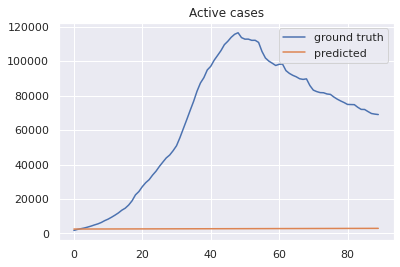

In [39]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

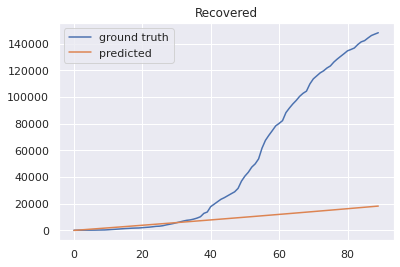

In [40]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

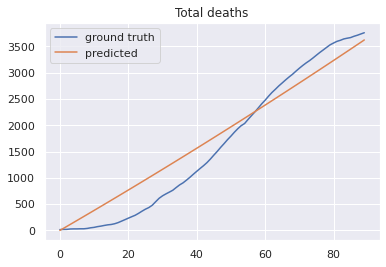

In [41]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

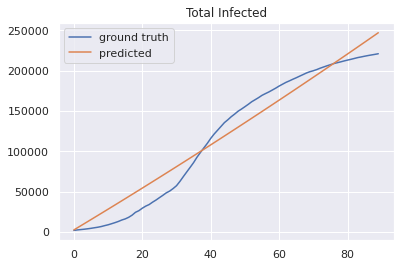

In [42]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total Infected')
plt.show()

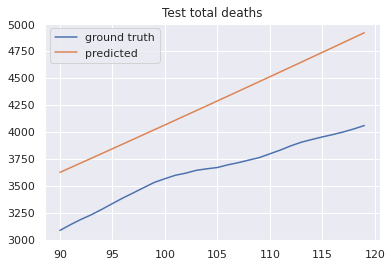

In [43]:
test_subset = df[len(subset):len(subset)+30]

test_t = np.arange(len(subset), len(subset)+len(test_subset))
S, I, R, D = model.predict_test(test_t)

plt.figure()
plt.plot(test_t, test_subset['total_dead'], label='ground truth')
plt.plot(test_t, D, label='predicted')
plt.legend()
plt.title('Test total deaths')
plt.show()

# SIR recent

In [44]:
model = SIROneStain(population)

subset = df[150:]
model.fit(subset)

S, I, R, D = model.predict_train()
result = model.fit_result_
result

In [45]:
R0 = result.params['beta']/result.params['gamma']
R0

0.9699792320159367

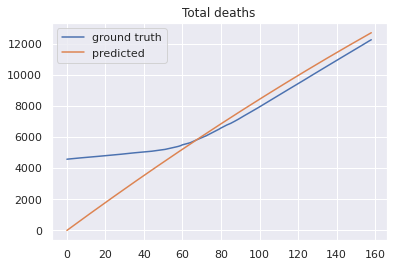

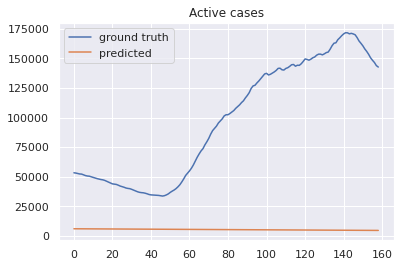

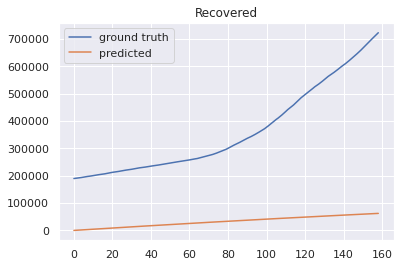

In [46]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

# SIR full

In [47]:
model = SIROneStain(population)
subset = df
model.fit(subset)

S, I, R, D = model.predict_train()

result = model.fit_result_
R0 = result.params['beta']/result.params['gamma']
R0

1.0550904931106408

In [48]:
result

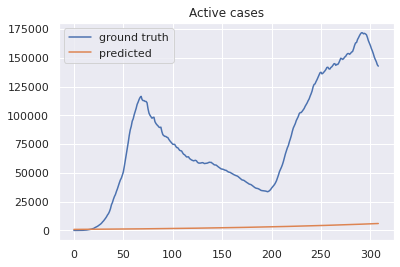

In [49]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

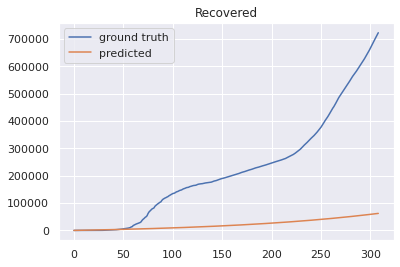

In [50]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

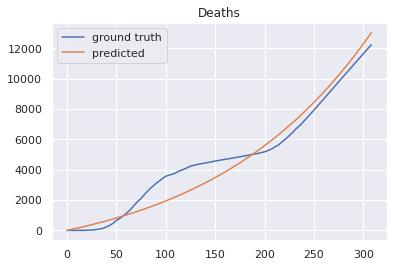

In [51]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Deaths')
plt.show()

# Evaluate predictive ability

In [52]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

In [53]:
tscv = TimeSeriesSplit(max_train_size=100, n_splits=10)

Fold 0
29 28


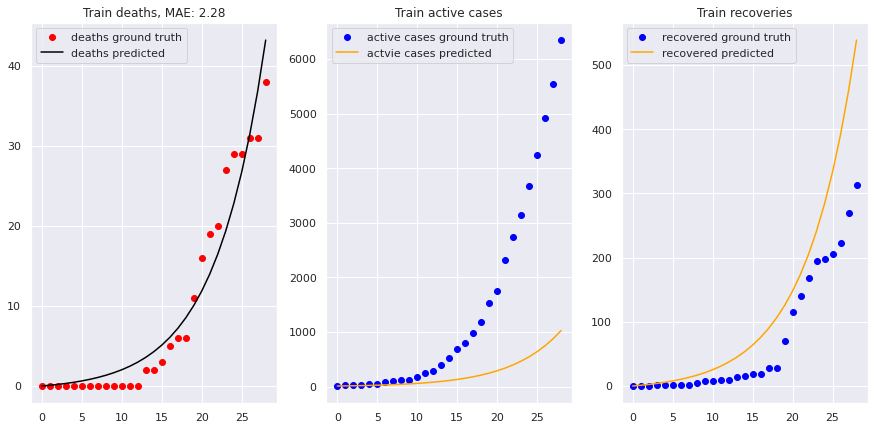

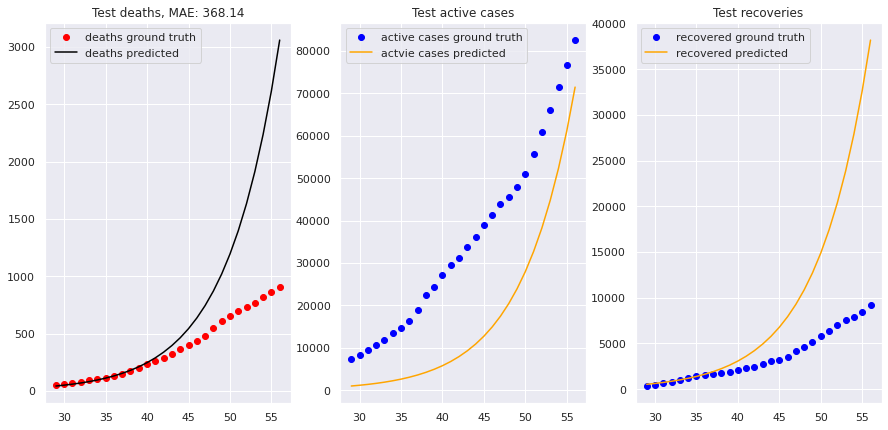

Test R^2: -5.216095677760447
Fold 1
57 28


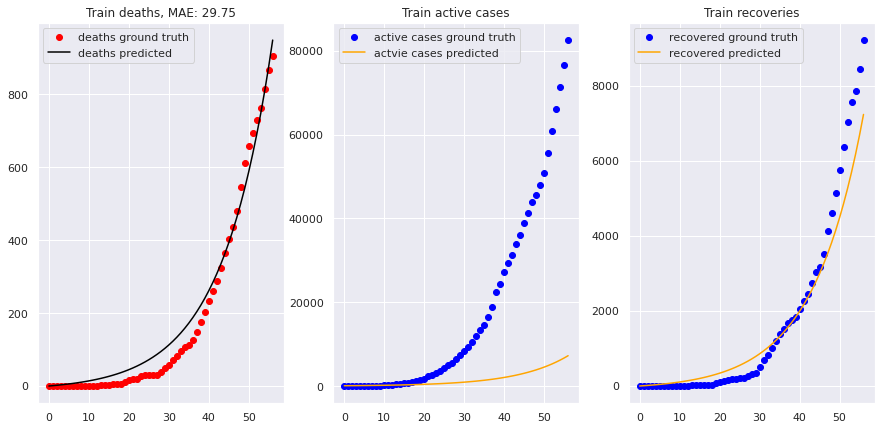

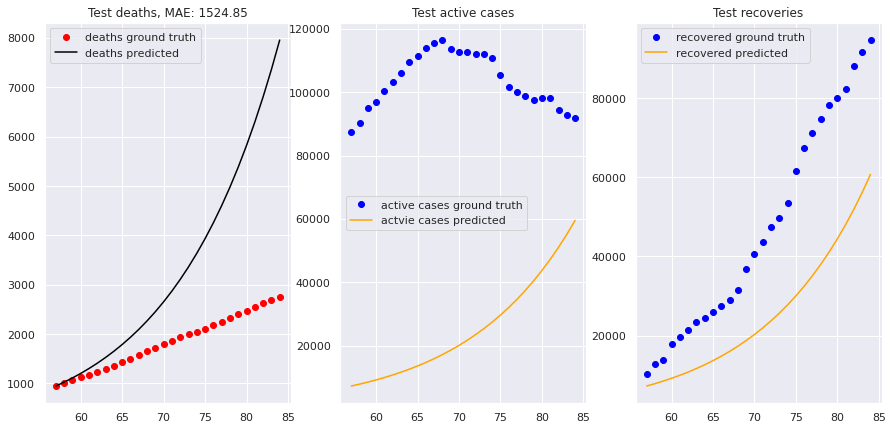

Test R^2: -14.525395253181392
Fold 2
85 28


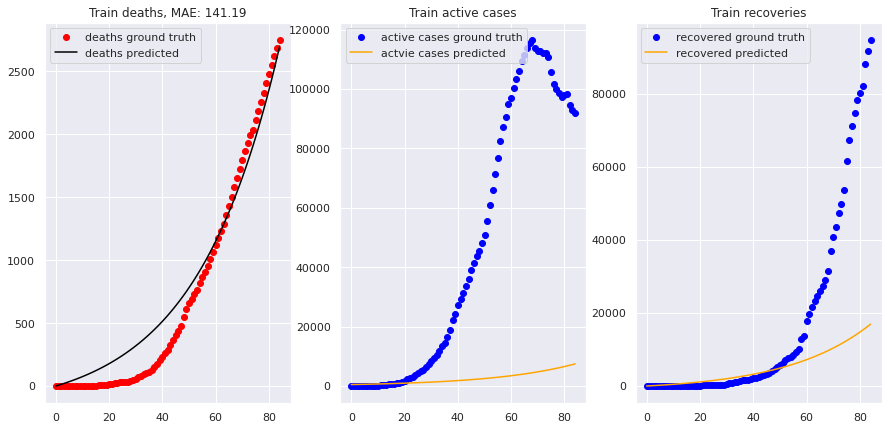

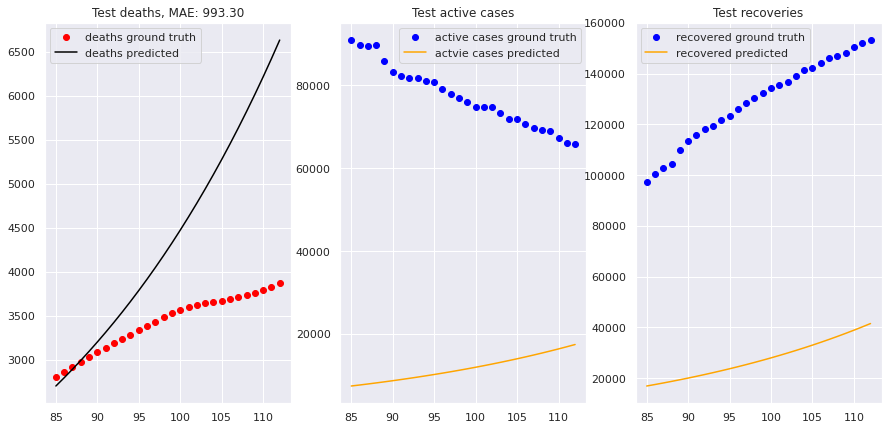

Test R^2: -16.423901856756277
Fold 3
100 28


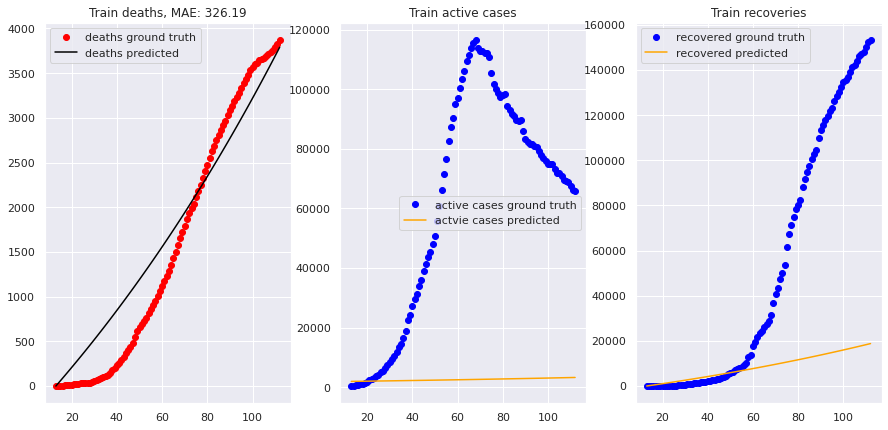

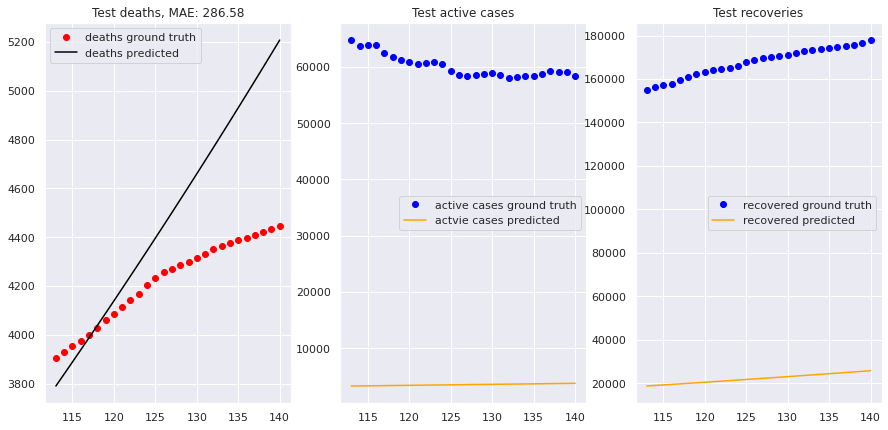

Test R^2: -3.8343112496902227
Fold 4
100 28


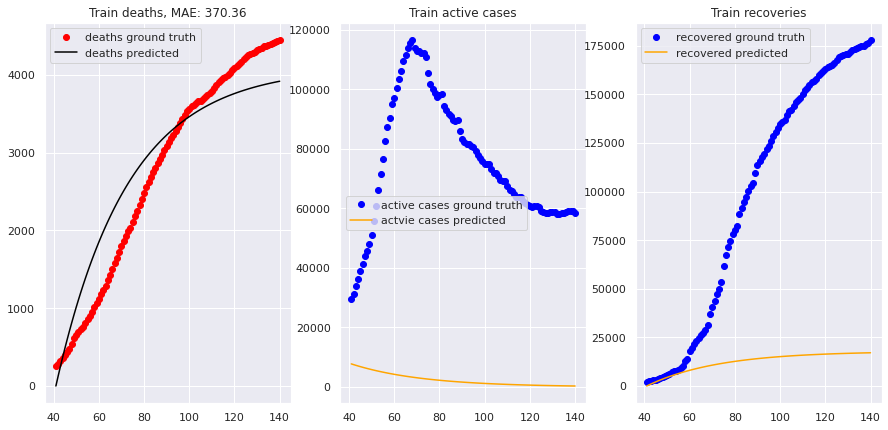

KeyboardInterrupt: 

In [54]:
maes = []
params = []
for i, (train_index, test_index) in enumerate(tscv.split(range(len(df)))):
    print('Fold', i)
    print(len(train_index), len(test_index))
    train_subset = df.iloc[train_index]
    test_subset = df.iloc[test_index]
    
    model = SIROneStain(population)
    model.fit(train_subset)

    result = model.fit_result_
    params.append(result.params)
    #result.plot_fit(datafmt="-")
    
    train_S, train_I, train_R, train_D = model.predict_train()
    S, I, R, D = model.predict_test(test_index)
    
    train_mae = mean_absolute_error(train_subset['total_dead'], train_D)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(train_index, train_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(train_index, train_D, label='deaths predicted', color='black')
    plt.title(f'Train deaths, MAE: {train_mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(train_index, train_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(train_index, train_I, label='actvie cases predicted', color='orange')
    plt.title(f'Train active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(train_index, train_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(train_index, train_R, label='recovered predicted', color='orange')
    plt.title(f'Train recoveries')
    plt.legend()
    plt.show()
    
    mae = mean_absolute_error(test_subset['total_dead'], D)
    maes.append(mae)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(test_index, test_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(test_index, D, label='deaths predicted', color='black')
    plt.title(f'Test deaths, MAE: {mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(test_index, test_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(test_index, I, label='actvie cases predicted', color='orange')
    plt.title(f'Test active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(test_index, test_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(test_index, R, label='recovered predicted', color='orange')
    plt.title(f'Test recoveries')
    plt.legend()
    plt.show()
    
    print('Test R^2:', r2_score(test_subset['total_dead'], D))

In [ ]:
params[-1]

In [ ]:
betas = [p['beta'] for p in params]
gamma = params[0]['gamma']
r0s = [b/gamma for b in betas]
r0s

plt.plot(r0s)
plt.title('R0 values per fold')
plt.show()

In [ ]:
r0s[-1]

In [ ]:
np.mean(maes)

In [ ]:
R[-1]

In [ ]:
I.cumsum()[-1] - R[-1] - D[-1]

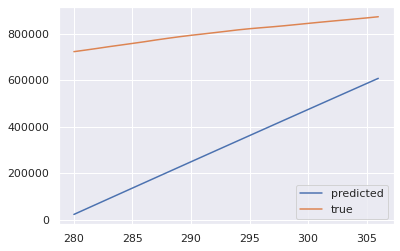

In [145]:
plt.plot(test_index, I.cumsum(), label='predicted')
plt.plot(test_index, test_subset.total_infected, label='true')
plt.legend()